In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip',origin=_URL,extract=True)
# tf.keras.utils.get_file has done so much that all files in zip are extracted to subfolders where they would be
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [4]:
train_dataset

<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>

In [5]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
# load mobilenetv2 without top layers
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False # the model is not trainable

In [7]:
# image_batch, label_batch = next(iter(train_dataset))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)'''

'image_batch, label_batch = next(iter(train_dataset))\nfeature_batch = base_model(image_batch)\nprint(feature_batch.shape)'

In [11]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.layers.RandomFlip('horizontal')(inputs)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomZoom(0.1)(x)
x = tf.keras.layers.Rescaling(1./127.5,offset=-1)(x)
x = base_model(x, training=False)  # batch normalization  will not update
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 160, 160, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 160, 160, 3)       0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 160, 160, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0   

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 55s 761ms/step - loss: 0.2018 - accuracy: 0.9100 - val_loss: 0.0907 - val_accuracy: 0.9666
Epoch 2/10
63/63 [==============================] - 53s 845ms/step - loss: 0.1913 - accuracy: 0.9190 - val_loss: 0.0917 - val_accuracy: 0.9678
Epoch 3/10
63/63 [==============================] - 54s 846ms/step - loss: 0.1781 - accuracy: 0.9245 - val_loss: 0.0861 - val_accuracy: 0.9666
Epoch 4/10
63/63 [==============================] - 53s 845ms/step - loss: 0.1810 - accuracy: 0.9235 - val_loss: 0.0800 - val_accuracy: 0.9703
Epoch 5/10
63/63 [==============================] - 40s 640ms/step - loss: 0.1762 - accuracy: 0.9155 - val_loss: 0.0789 - val_accuracy: 0.9740
Epoch 6/10
63/63 [==============================] - 42s 667ms/step - loss: 0.1833 - accuracy: 0.9120 - val_loss: 0.0753 - val_accuracy: 0.9740
Epoch 7/10
63/63 [==============================] - 44s 699ms/step - loss: 0.1707 - accuracy: 0.9240 - val_loss: 0.0774 - val_accuracy: 0.9728

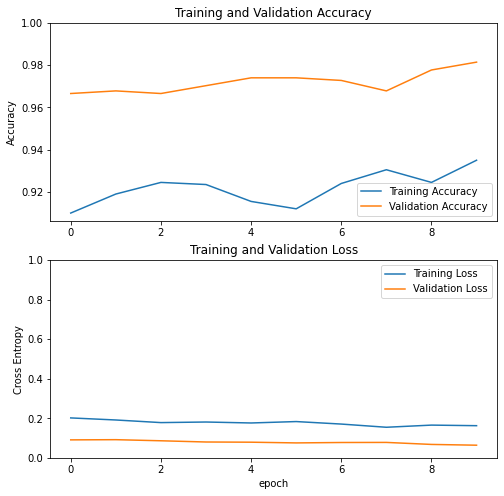

In [16]:
def viewHistory(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

viewHistory(history)

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable = True
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
history_fine = model.fit(train_dataset,
                         epochs=history.epoch[-1]+10,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)
viewHistory(history_fine)

Number of layers in the base model:  154
Epoch 10/19
63/63 [==============================] - 78s 1s/step - loss: 0.0930 - accuracy: 0.9585 - val_loss: 0.0321 - val_accuracy: 0.9876
Epoch 11/19
63/63 [==============================] - 58s 916ms/step - loss: 0.0738 - accuracy: 0.9715 - val_loss: 0.0291 - val_accuracy: 0.9901
Epoch 12/19
63/63 [==============================] - ETA: 0s - loss: 0.0857 - accuracy: 0.9635